In [1]:
xvars = [:dchrppd,
    :dchrppd_lag,
    :logdchrppd,
    :logdchrppd_lag,
    :rnhrppd,
    :rnhrppd_lag,
    :logrnhrppd,
    :logrnhrppd_lag,
    :lpnhrppd,
    :lpnhrppd_lag,
    :loglpnhrppd,
    :loglpnhrppd_lag,
    :cnahrppd,
    :cnahrppd_lag,
    :logcnahrppd,
    :logcnahrppd_lag,
    :labor_expense,
    :labor_expense_lag,
    :loglabor_expense,
    :loglabor_expense_lag,
    :rn_frac
]


logged_inds = [3, 4, 7, 8, 11, 12, 15, 16, 19, 20] # for the modified elasticity computation
qvars = [:restot, :nres_mcare, :nres_nonmcaid]

using DataFrames, Optim, Revise, Serialization, Statistics
# using DataFrames, Optim, Revise, Serialization, DebuggingUtilities, CSV, Statistics

const datadir = "/export/storage_adgandhi/MiscLi/factract";
string(@__DIR__) in LOAD_PATH || push!(LOAD_PATH, @__DIR__);
using BLPmodule; const m = BLPmodule;



In [2]:


d_ind = [3] #which distance variable. 1=d, 2=d2, 3=log(d)

testmodes = ["_FL17", ""]
testmode = testmodes[1]

suble = true #select only a subset facilities based on (log)labor_expense(_lag)


true

In [5]:
x_ind = [20]
q_ind = 2
println("X variable: ", xvars[x_ind])
println("Q variable: ", qvars[q_ind])

logit = false

X variable: [:loglabor_expense_lag]
Q variable: nres_mcare


false

In [6]:

x_tag = join(string.(x_ind))
d_tag = join(string.(d_ind))
configtag = "$(q_ind)_$(x_tag)_$(d_tag)$testmode"

ec = deserialize("$datadir/analysis/ec$q_ind$testmode.jls");

# linear characteristics (staffing variables):
X1 = vcat(transpose.([ec.firms[ii].X[x_ind] for ii in eachindex(ec.firms)])...);
Z = vcat(transpose.([ec.firms[ii].Z for ii in eachindex(ec.firms)])...);




In [7]:


if !logit
    pars = m.set_Pars(K = length(d_ind), nJ=length(ec.firms));
    function closure_gmm(θ2)
        return m.gmm_lm(θ2, ec, pars, X1, Z; d_ind)
    end
    
    res = optimize(closure_gmm, -2., 8., show_trace = false, abs_tol= 1e-4)
else
    pars = m.set_Pars(K = length(d_ind), nJ=length(ec.firms), nI = 1);
    res = m.gmm_lm(0., ec, pars, X1, Z; d_ind)
end


Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-2.000000, 8.000000]
 * Minimizer: 1.917820e+00
 * Minimum: 1.145827e+02
 * Iterations: 11
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+1.0e-04): true
 * Objective Function Calls: 12

In [9]:
share = [tt.shares for tt in ec.tracts];
mktq = [tt.q for tt in ec.tracts];


In [10]:
δ = pars.δs;


In [14]:
if suble
    x_sub = [ff.X[x_ind][1] for ff in ec.firms]
    x_subind = x_sub .< quantile(x_sub, 0.95)
    δ_ = δ[x_subind]
    X1_ = X1[x_subind, :]
else
    δ_ = δ
    X1_ = X1
end
;

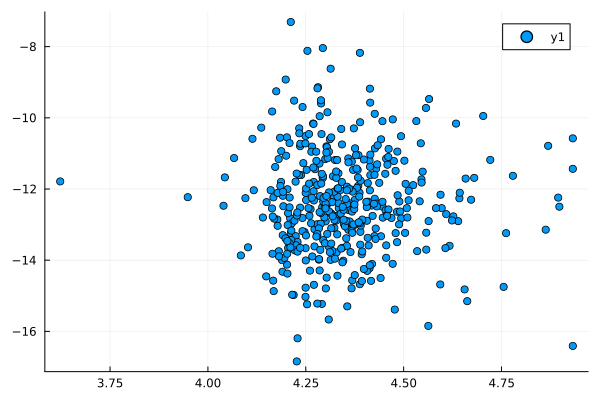

In [15]:
using Plots
plot(X1 , δ, seriestype=:scatter)


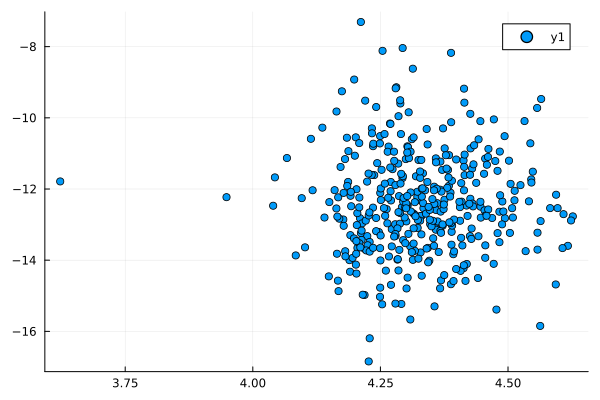

In [16]:
plot(X1_ , δ_, seriestype=:scatter)


In [17]:

θ1res = X1_ \ δ_
println("θ1: ", θ1res)

θ1: 

[-2.8650231283675467]
